# FER 
We write a notebook for FER analysis

## Preliminars

In [ ]:
from google.colab import drive
drive.mount("/content/drive/",force_remount=True)

Mounted at /content/drive/


In [ ]:
!pip install facenet-pytorch 
!pip install mtcnn
!apt install libomp-dev
!pip install faiss
!pip install faiss-gpu

     |████████████████████████████████| 1.9 MB 12.8 MB/s 
     |████████████████████████████████| 2.3 MB 13.3 MB/s 
Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libomp5
Suggested packages:
  libomp-doc
The following NEW packages will be installed:
  libomp-dev libomp5
0 upgraded, 2 newly installed, 0 to remove and 37 not upgraded.
Need to get 239 kB of archives.
After this operation, 804 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp5 amd64 5.0.1-1 [234 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libomp-dev amd64 5.0.1-1 [5,088 B]
Fetched 239 kB in 0s (2,380 kB/s)
Selecting previously unselected package libomp5:amd64.
(Reading database ... 155222 files and directories currently installed.)
Preparing to unpack .../libomp5_5.0.1-1_amd64.deb ...
Unpacking libomp5:amd64 (5.0.1-1) ...
Selecting previousl

In [ ]:
# UTILS
import os
import imutils
import numpy as np
import pandas as pd
import cv2 as cv2
import glob
import matplotlib.pyplot as plt
import skimage as sk
from skimage import transform
import copy
import torch

#FACE DETECTION

#from mtcnn.mtcnn import MTCNN 
from facenet_pytorch import MTCNN
from PIL import Image
from tqdm.notebook import tqdm
import mtcnn.mtcnn
import re

#EXTRACT FEATURES
import itertools
from skimage import feature
from matplotlib import cm

#LAPLACE EIGENMAPS
from __future__ import print_function
import numpy as np
import time
import os
import faiss
from multiprocessing.dummy import Pool as ThreadPool
from scipy.linalg import eigh
from scipy.linalg import pinvh


#ClASSIFICATION
import sklearn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier


main_path = '/content/drive/MyDrive/Images'

#TORCH config
name = 'PyTorch\nGPU'
torchdevice = 0
if torch.cuda.is_available():
  device = torch.device('cuda:{}'.format(torchdevice))
else:
  device = 'cpu'
print('{} available: {}'.format(name, torch.cuda.is_available()))

PyTorch
GPU available: False


## Data extraction

In [ ]:
def _process_row(row):
    """
    Process a single dataframe row, returns the argmax label
    :param row:
    :return:
    """
    return np.argmax(row)

In [ ]:
train_path = os.path.join( main_path, 'FER2013Train' )
test_path = os.path.join( main_path, 'FER2013Test' )
valid_path = os.path.join( main_path, 'FER2013Valid' )

#initialize dataframe FER+ with actuall images in folder (some might be missing or duplicates)
def get_DataFrame( path_name ):
    label_file = os.path.join(path_name, 'label.csv')
    data_df = pd.read_csv(label_file, header=None)
    data_df.columns = ["img_name", "dims", "0", "1", "2", "3", "4", "5", "6", "7","Unknown", "NF"]
    data_df['actual_label'] = data_df[['0', '1', '2', '3', '4', '5', '6', '7']].apply(lambda x: _process_row(x), axis=1)

    # get all ilocs with actual label 0
    data_df = data_df.sort_values(by=['img_name'])
    image_file_names = data_df['img_name'].values
    d_files = [ filename.split('/')[-1] for filename in glob.glob(path_name+'/*.*') ]
    data_df['exist_file'] = [ 1 if ii in d_files else np.nan for ii in image_file_names ]
    return data_df.dropna()

#reads image in cv2 format, transforms to grayscale since many operations needs this
def get_Image( path ):
    return cv2.imread( path, cv2.IMREAD_GRAYSCALE )

#converts gray image to string
def _grayimg2string( img ):
    return str(img.flatten().tolist()).replace(']','').replace('[','')

#converts string to gray image
def _string2grayimage( img, size=(48,48) ):
    return np.array(img.split(', ')).astype(np.uint8).reshape( size )


#creates dataframes per emotion loading images in gray scale
def get_emotionsDataFrames( path_name, data_df ):
    for ii in data_df['actual_label'].unique():
        dd = data_df[data_df['actual_label']==ii][['img_name','actual_label']]
        dd['img_str'] = dd['img_name'].apply(lambda x: _grayimg2string( get_Image( path_name+'/'+x ) ) )
        dd.to_csv(path_name+'/'+f'labels_{ii}.csv', index=False)
    return

In [ ]:
#get_emotionsDataFrames( train_path, get_DataFrame( train_path ) )
#get_emotionsDataFrames( test_path, get_DataFrame( test_path ) )
#get_emotionsDataFrames( valid_path, get_DataFrame( valid_path ) )
#this was run localy and the results are in /content/drive/MyDrive/Images/labels 
!ls /content/drive/MyDrive/Images/labels 

test_labels_0.csv  test_labels_6.csv   train_labels_4.csv  valid_labels_2.csv
test_labels_1.csv  test_labels_7.csv   train_labels_5.csv  valid_labels_3.csv
test_labels_2.csv  train_labels_0.csv  train_labels_6.csv  valid_labels_4.csv
test_labels_3.csv  train_labels_1.csv  train_labels_7.csv  valid_labels_5.csv
test_labels_4.csv  train_labels_2.csv  valid_labels_0.csv  valid_labels_6.csv
test_labels_5.csv  train_labels_3.csv  valid_labels_1.csv  valid_labels_7.csv


## Preprocessing

In [ ]:
#example read data
stringi = 'test_labels_0.csv'
test_labels_0 = pd.read_csv( main_path+'/labels/'+stringi) 

In [ ]:
#For plotting image
def show( img ):
    plt.imshow( img, cmap='gray' )
    return

#Cleaning noise
def Denoising( img, h=10, templateWindowSize=7, searchWindowSize=21 ):
    return cv2.fastNlMeansDenoising(img,None,h,templateWindowSize,searchWindowSize)

#Run denoising
def RunDenoising( df ):
  return [ Denoising( _string2grayimage( img ) ) for img in df['img_str'] ] 

In [ ]:
#detect faces with mtcnn
# we use this library after reading https://towardsdatascience.com/face-detection-models-which-to-use-and-why-d263e82c302c
# info in https://www.kaggle.com/timesler/guide-to-mtcnn-in-facenet-pytorch#Bounding-boxes-and-facial-landmarks
detector = mtcnn.mtcnn.MTCNN()
def ReturnLocalizedFace( img ):
    faces = detector.detect_faces( cv2.cvtColor( img, cv2.COLOR_GRAY2RGB ) )
    return faces

#for many faces
def ReturnLocalizedManyFaces( manyimgs ):
    detector = MTCNN( keep_all=True, device=device, post_process=False, select_largest=False)
    imgs = []
    for img in manyimgs:
      imgs.append( Image.fromarray( cv2.cvtColor( img, cv2.COLOR_GRAY2RGB ) ) )
    
    batch_boxes, _, batch_landmarks= detector.detect( imgs, landmarks=True )
    return batch_boxes, batch_landmarks #manyfaces

#draw faces result from mtcnn (https://towardsdatascience.com/face-detection-using-mtcnn-a-guide-for-face-extraction-with-a-focus-on-speed-c6d59f82d49)
def DrawFacesMTCNN( img, faces ):
    plt.imshow( img, cmap='gray' )
    ax = plt.gca()
    for face in faces:
        x, y, w, h = face['box']
        rect = plt.Rectangle( (x,y), w, h , fill=False, color='green', lw=1 )
        ax.add_patch( rect )
        for key, value in face['keypoints'].items():
            dot = plt.Circle( value, radius=1, color='red' )
            ax.add_patch( dot )
    plt.show()
    return

#detect faces and uses eye-eye position to rotates and match a given "standard" 
def RotatetoFrontalFace( img, faces ):
    #target positions from image FER2013Test/fer0032232.png
    le_t = np.array([13,18],dtype=float)
    re_t = np.array([35,18],dtype=float)
    no_t = np.array([24,30],dtype=float)
    ml_t = np.array([17,41],dtype=float)
    mr_t = np.array([31,41],dtype=float)
    eye_separation = re_t[0]-le_t[0]
    
    #faces = ReturnLocalizedFace( img )
    if len(faces)!=1:
        return None
    
    le=faces[0].get('keypoints').get('left_eye')
    if not le:
        return None
    le=np.array(le,dtype=float)
    re=faces[0].get('keypoints').get('right_eye')
    if not re:
        return None    
    re=np.array(re,dtype=float)
    
    lr = re - le
    lr_n = np.linalg.norm(lr)
    c_alph = lr[0]/lr_n
    sgn = np.sign(lr[1])
    s_alph = sgn*np.sqrt(1-c_alph**2)
    scale = eye_separation/lr_n
    
    rot_mat = np.array([[  scale*c_alph,  scale*s_alph,  -scale*c_alph*le[0]+le_t[0]-scale*s_alph*le[1] ],
                      [ -scale*s_alph,  scale*c_alph,  -scale*c_alph*le[1]+le_t[1]+scale*s_alph*le[0] ]])
    
    new_img = cv2.warpAffine( img, rot_mat, img.shape)
    #return crop image in size of "standard"
    return new_img[0:48, 0:48]

In [ ]:
manyimgs =  RunDenoising( test_labels_0 )

In [ ]:
# we pad the images so facenet_pytorch has similar results to mtcnn.mtcnn
manyimgs_pad = [cv2.copyMakeBorder(img, 20, 20, 20, 20, cv2.BORDER_CONSTANT) for img in manyimgs]

In [ ]:
faces,landmarks=ReturnLocalizedManyFaces(manyimgs_pad)

/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/utils/detect_face.py:183: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  batch_boxes, batch_points = np.array(batch_boxes), np.array(batch_points)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:339: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  boxes = np.array(boxes)
/usr/local/lib/python3.7/dist-packages/facenet_pytorch/models/mtcnn.py:341: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndar

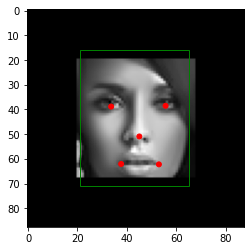

[{'box': array([21, 16, 44, 55]),
  'keypoints': {'left_eye': array([33.619476, 38.83419 ], dtype=float32),
   'mouth_left': array([37.673756, 62.071255], dtype=float32),
   'mouth_right': array([52.956753, 62.229015], dtype=float32),
   'nose': array([45.033806, 50.93828 ], dtype=float32),
   'right_eye': array([55.64639 , 38.519268], dtype=float32)}}]

In [ ]:
ii=2
face= [{'box':np.hstack((faces[ii][0][0:2],faces[ii][0][2:4]-faces[ii][0][0:2])).astype(np.int),
        'keypoints':{'left_eye':landmarks[ii][0][0] ,'right_eye':landmarks[ii][0][1] ,'nose':landmarks[ii][0][2] ,
                                             'mouth_left':landmarks[ii][0][3] , 'mouth_right':landmarks[ii][0][4] }}]
DrawFacesMTCNN( manyimgs_pad[ii], face )
face

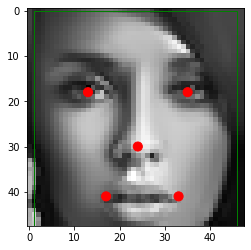

[{'box': [1, 0, 45, 52],
  'confidence': 0.9999600648880005,
  'keypoints': {'left_eye': (13, 18),
   'mouth_left': (17, 41),
   'mouth_right': (33, 41),
   'nose': (24, 30),
   'right_eye': (35, 18)}}]

In [ ]:
face_0=ReturnLocalizedFace(manyimgs[ii])
DrawFacesMTCNN(manyimgs[ii],face_0)
face_0

In [ ]:
df2=pd.DataFrame([ {'left_eye':ii[0][0]-20,'right_eye':ii[0][1]-20,'nose':ii[0][2]-20,'mouth_left':ii[0][3]-20,'mouth_right':ii[0][4]-20} if ii is not None else {} for ii in landmarks]).dropna()
df2

,left_eye,right_eye,nose,mouth_left,mouth_right
0,"[15.175892, 13.462845]","[36.330505, 16.309948]","[24.481308, 26.22726]","[14.27211, 35.40188]","[30.717548, 37.91584]"
1,"[10.33625, 25.163097]","[24.958424, 18.154633]","[17.881508, 31.351383]","[18.297325, 40.739212]","[29.888481, 34.888412]"
2,"[13.619476, 18.83419]","[35.64639, 18.519268]","[25.033806, 30.938278]","[17.673756, 42.071255]","[32.956753, 42.229015]"
5,"[12.928093, 17.635086]","[34.888683, 16.390663]","[26.5625, 31.364922]","[16.894493, 43.87712]","[33.53099, 42.95771]"
6,"[28.700783, 24.448666]","[35.37115, 26.394402]","[33.656395, 31.134422]","[25.90229, 35.4606]","[30.62233, 36.5999]"
...,...,...,...,...,...
1269,"[13.6345825, 14.701927]","[35.125755, 14.197777]","[27.051235, 29.427135]","[17.09114, 40.721416]","[32.471497, 40.447956]"
1270,"[15.37735, 18.016586]","[34.399303, 18.644402]","[21.553047, 29.096706]","[15.987686, 37.913933]","[31.17746, 38.707287]"
1271,"[15.770264, 25.050713]","[32.67327, 23.840057]","[23.527168, 32.468113]","[18.469097, 42.76113]","[32.11705, 41.880714]"
1272,"[15.7985, 19.413765]","[33.078785, 19.818863]","[24.963692, 30.27922]","[16.820686, 39.03609]","[30.600513, 39.441185]"


In [ ]:
#for filename in glob.glob(main_path+'/labels/*.*'):
#    print(filename)
#    fileout = re.search(r'(\w+).csv',filename).group(0)
#    df = pd.read_csv( filename )
#    manyimgs =  RunDenoising( df )
#    manyimgs_pad = [ cv2.copyMakeBorder(img, 20, 20, 20, 20, cv2.BORDER_CONSTANT) for img in manyimgs ]
#    faces,landmarks = ReturnLocalizedManyFaces(manyimgs_pad)
#    df2 = pd.DataFrame([ {'left_eye':ii[0][0]-20,'right_eye':ii[0][1]-20,'nose':ii[0][2]-20,'mouth_left':ii[0][3]-20,
#                        'mouth_right':ii[0][4]-20} if ii is not None else {} for ii in landmarks]).join(test_labels_0)[['img_name','left_eye','right_eye']].dropna()
#    df2.to_csv(main_path+'/faciallandmarks/K_'+fileout)

#this was run with gpus result in google drive
!ls /content/drive/MyDrive/Images/faciallandmarks/

K_test_labels_0.csv  K_train_labels_0.csv  K_valid_labels_0.csv
K_test_labels_1.csv  K_train_labels_1.csv  K_valid_labels_1.csv
K_test_labels_2.csv  K_train_labels_2.csv  K_valid_labels_2.csv
K_test_labels_3.csv  K_train_labels_3.csv  K_valid_labels_3.csv
K_test_labels_4.csv  K_train_labels_4.csv  K_valid_labels_4.csv
K_test_labels_5.csv  K_train_labels_5.csv  K_valid_labels_5.csv
K_test_labels_6.csv  K_train_labels_6.csv  K_valid_labels_6.csv
K_test_labels_7.csv  K_train_labels_7.csv  K_valid_labels_7.csv


## Feature extraction

In [ ]:
# Gabor filter in frequency domain as in https://www.ini.rub.de/upload/file/1470692845_33efbf50567f9d637771/LadEtAl1993.pdf
# https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.541.2926&rep=rep1&type=pdf)
def Gabor_filter(u,v):

  k_m = np.pi/2
  f = np.sqrt(2)
  s = np.pi #(or np.pi)
  tet = np.pi*u/8
  cx = np.cos(tet)*k_m/(f**v)
  cy = np.sin(tet)*k_m/(f**v)
  k2 = cx**2+cy**2

  def Gabor_space(x,y):
    return k2/s**2*np.exp(-k2*(x**2+y**2)/(2*s**2))*(np.exp((cx*x+cy*y)*1j)-np.exp(-s**2/2))

  def Gabor_freq(kx,ky):
    return (np.exp(-s**2*((cx-2*np.pi*kx)**2+(cy-2*np.pi*ky)**2)/(2*k2))-np.exp(-s**2*(k2+(kx**2+ky**2)*4*np.pi**2)/(2*k2)))*2*np.pi

  aa = np.array([[Gabor_space(ii,jj) for ii in range(-24,24)] for jj in range(-24,24)]) 
  #bb = np.array([[Gabor_freq(ii/(48),jj/(48)) for ii in range(-0,48)] for jj in range(-0,48)])
  return aa.real


u_l = [ 0, 1, 2, 3, 4, 5, 6, 7 ]
v_l = [ 0, 1, 2, 3, 4 ]
filters = [ Gabor_filter(u,v) for u,v in itertools.product( u_l, v_l ) ]


##s1 = np.array(img_p.shape)
##s2 = np.array(filter_p.shape )
##size = s1+s2+1
##fsize = 2**np.ceil(np.log2(size)).astype(int)
###fslice = tuple([slice(0, int(sz)) for sz in size]) =(128, 128)
##fslice = (slice(24, 24+48), slice(24,24+48) )

##img_t = np.fft.fft2(img_p,fsize)
##filter_t = np.fft.fft2(filter_p,fsize)
##img_b = np.fft.ifft2( img_t*filter_t )[fslice].copy()

fft_filters = [ torch.fft.fft2(torch.tensor(filt, device=device), (128,128) ) for filt in filters ] 

array([0.01649306, 0.04253472, 0.04036458, 0.14279514, 0.47092014,
       0.13541667, 0.03038194, 0.03862847, 0.03776042, 0.04470486])

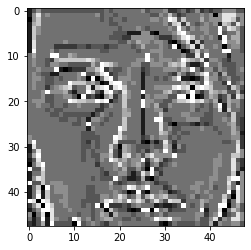

In [ ]:
radius=1
npoints=8*radius
aa=feature.local_binary_pattern(manyimgs[2],npoints,radius,method='uniform')
show(aa)
hist,_=np.histogram(aa.ravel(), bins=np.arange(0,npoints  + 3),range=(0, npoints + 2))
hist = hist.astype("float")
hist /= (hist.sum() + 1e-7)
hist

In [ ]:
#Extract LBP Features 
# divides in 7X7 squares as in https://www.pyimagesearch.com/2021/05/03/face-recognition-with-local-binary-patterns-lbps-and-opencv/
# class based in https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/
class LocalBinaryPatterns:
    def __init__( self, numPoints, radius):
        self.numPoints = numPoints
        self.radius = radius
        
    def describe(self, image, eps=1e-7):    
        lbp = feature.local_binary_pattern(image, self.numPoints, self.radius, method="uniform")
        (hist, _) = np.histogram(lbp.ravel(), bins=np.arange(0, self.numPoints + 3),
            range=(0, self.numPoints + 2))
        # normalize the histogram
        hist = hist.astype("float")
        hist /= (hist.sum() + eps)
        # return the histogram of Local Binary Patterns
        return hist

LBPdesc = LocalBinaryPatterns(8, 1)

def ExtractLBPHist( img, LBPdesc ):
    LBP = []
    for ii in range(0,7):
        for jj in range(0,7):
            hist = LBPdesc.describe( img[ ii*7:(ii+1)*7, jj*7:(jj+1)*7 ] )
            LBP.append(hist)
    return LBP

In [ ]:
#Extracts HOG
def ExtractHOG( img, win_size=(64,64) ):    
    
    img = cv2.resize( img, win_size )
    winSize = (64,64)
    blockSize = (16,16)
    blockStride = (8,8)
    cellSize = (8,8)
    nbins = 4

    d = cv2.HOGDescriptor(winSize,blockSize,blockStride,cellSize,nbins)
    hog = d.compute( img )
    ss = hog.shape[0]
    return hog.reshape(ss,)

In [ ]:
#img+faces->denoise->rotate->hog+lbp & (fft -> *gabor filter -> ifft -> hog+lbp)
stringi = 'test_labels_0.csv'
data_path = main_path + '/labels/' + stringi
landmarks_path = main_path + '/faciallandmarks/K_' + stringi

def _RotationFace( img_str, le, re ):
    img = Denoising( _string2grayimage( img_str ))
    le_d = le.replace(']','').replace('[','').split()
    re_d = re.replace(']','').replace('[','').split()
    faces = [ {'keypoints': {  'left_eye': le_d, 'right_eye':re_d } } ] 
    return img, faces

def _FeaturesperImage( img ):
  features = []
  features.append( ExtractHOG( img ) )
  features.append( ExtractLBPHist( img, LBPdesc ))
  img_t = torch.fft.fft2( torch.tensor( img, device=device ), (128,128) ) 
  fslice = (slice(24, 24+48), slice(24,24+48) )

  for filt in fft_filters:
    img_f = torch.fft.ifft2( torch.mul( filt, img_t ) ).cpu().numpy()[fslice].copy() 
    img_f = ((img_f.real-img_f.real.min())*255/(img_f.real.max()-img_f.real.min())).astype(np.uint8)
    
    features.append( ExtractHOG( img_f ) )
    features.append( ExtractLBPHist( img_f, LBPdesc ))
  
  return features   

def FeatureExtraction( data_path, landmarks_path ):
  df = pd.read_csv( data_path )
  df = pd.DataFrame.join( df[['img_name','actual_label']], df['img_str'].drop_duplicates(), how='inner' )
  data = pd.DataFrame.join( df, pd.read_csv( landmarks_path, index_col=0 )[['left_eye','right_eye']], how='inner' )

  rotated_img = [ RotatetoFrontalFace( *_RotationFace(img_str, le, re) ) for img_str, le, re in zip(data['img_str'], data['left_eye'], data['right_eye']) ]
  img_descr = [ [img_name, actual_label]  for img_name, actual_label in zip(data['img_name'], data['actual_label']) ]
  return rotated_img, img_descr


In [ ]:
aa,_ = FeatureExtraction(data_path,landmarks_path)

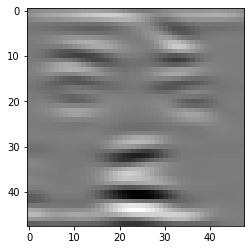

In [ ]:
img_p = aa[2]
filter_p = filters[21]

s1 = np.array(img_p.shape)
s2 = np.array(filter_p.shape )

size = s1+s2+1

fsize = 2**np.ceil(np.log2(size)).astype(int)
#fslice = tuple([slice(0, int(sz)) for sz in size])
fslice = (slice(24, 24+48), slice(24,24+48) )

img_t = np.fft.fft2(img_p,fsize)
filter_t = np.fft.fft2(filter_p,fsize)

img_b = np.fft.ifft2( img_t*filter_t )[fslice].copy()

img = ((img_b?kernel_name=python3.real-img_b.real.min())*255/(img_b.real.max()-img_b.real.min()))#.astype(np.uint8)

show(img)#img_t.cpu().numpy().imag)


array([[ 0,  0,  0, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  0,  0,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       ...,
       [62, 59, 51, ...,  1,  1,  1],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

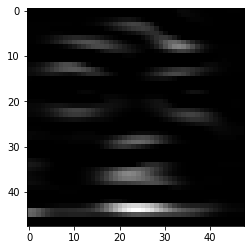

In [ ]:
show( cv2.filter2D( img_p, cv2.CV_8UC3, filter_p.real ))
cv2.filter2D( img_p, cv2.CV_8UC3, filter_p.real )

In [ ]:
aa0_features=_FeaturesperImage(aa[0])

In [ ]:
#number of features = 784 * #HOG (41) + 49 * 10 * #LBP (41) =  52 234
print( len(aa0_features) )
print( aa0_features[0].shape )
print( len(aa0_features[1]) )
print( aa0_features[1][0].shape )
%xdel aa

82
(3780,)
49
(10,)


In [ ]:
stringi = 'valid'
def ExtractFeatures_manyimgs(stringi):
  x = []
  y = []
  for filename in glob.glob(main_path+'/labels/'+stringi+'*.*'):
    file_string = re.search(r'(\w+).csv',filename).group(0)
    print( file_string )
    landmarks_path = main_path + '/faciallandmarks/K_' + file_string
    rot_imgs, imgs_des = FeatureExtraction(filename,landmarks_path)
    for ii in tqdm(range(len(rot_imgs))): 
      xi = _FeaturesperImage( rot_imgs[ii] )
      x.append( xi )
      y.append( imgs_des[ii] )

  return x, y



#x,y = ExtractFeatures_manyimgs(stringi)

#x=np.array(x)
#y=np.array(y)

#x_out = np.zeros((x.shape[0],52234),dtype='float32')

#for ii in tqdm(range(x.shape[0])):
#  x_o =[]
#  for xxi in x[ii]:
#    x_o.extend(np.ravel(xxi))
#  x_out[ii][:]=np.array(x_o).astype('float32')[:]

#fileout_path = main_path + '/memap_AllFeatures_'+stringi.capitalize()

#fpx = np.memmap( fileout_path+'_X', dtype='float32', mode='w+', shape=x_out.shape )
#fpx[:] = x_out[:]
#fpx.flush()
#fpy = np.memmap( fileout_path+'_y', dtype='<U14', mode='w+', shape=y.shape )
#fpy[:] = y[:]
#fpy.flush()

#print(x_out.shape)

#this was run with gpus result in google drive for stringi = 'test'(3044,dim), 'valid'(2978,dim), 'train'(5958,dim), results saved in drive
!ls /content/drive/MyDrive/Images/memap*

valid_labels_6.csv


  0%|          | 0/60 [00:00<?, ?it/s]

valid_labels_1.csv


  0%|          | 0/795 [00:00<?, ?it/s]

valid_labels_2.csv


  0%|          | 0/380 [00:00<?, ?it/s]

valid_labels_5.csv


  0%|          | 0/26 [00:00<?, ?it/s]

valid_labels_4.csv


  0%|          | 0/281 [00:00<?, ?it/s]

valid_labels_0.csv


  0%|          | 0/1094 [00:00<?, ?it/s]

valid_labels_3.csv


  0%|          | 0/319 [00:00<?, ?it/s]

valid_labels_7.csv


  0%|          | 0/23 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:21: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


  0%|          | 0/2978 [00:00<?, ?it/s]

(2978, 52234)


## Laplace EIgenMap

In [ ]:
#@title
dbname = 'memap_AllFeatures_Train_X'
dim = 52234
nnn = 1024    #for our dataset 1.5 x mean number of elements per class is 1148  so nnn=1024 is good enough  
cacheroot = '/content/drive/MyDrive/faissdata'



#taken from:
#   cpu: https://github.com/facebookresearch/faiss/blob/main/benchs/bench_for_interrupt.py
#   gpu: https://github.com/facebookresearch/faiss/blob/main/benchs/bench_gpu_1bn.py
ngpu = 0#faiss.get_num_gpus()
add_batch_size = 1000
nprobe = 640
query_batch_size = 16384
knngraph = True
num_elements = 10000
key = 'IVF100,PQ70'
train_index = False

if not os.path.isdir(cacheroot):
    print("%s does not exist, creating it" % cacheroot)
    os.mkdir(cacheroot)


if knngraph:
    gt_cachefile = '%s/BK_gt_%s' % (cacheroot, dbname)
    prefix = 'BK_'

#################################################################
# Small Utility Functions
#################################################################

# we mem-map the biggest files to avoid having them in memory all at
# once

def mmap_fvecs(fname):
    x = np.memmap(fname, dtype='float32', mode='r', shape=(num_elements,dim))
    return x.view()


def rate_limited_imap(f, l):
    """A threaded imap that does not produce elements faster than they
    are consumed"""
    pool = ThreadPool(1)
    res = None
    for i in l:
        res_next = pool.apply_async(f, (i, ))
        if res:
            yield res.get()
        res = res_next
    yield res.get()

class IdentPreproc:
    """a pre-processor is either a faiss.VectorTransform or an IndentPreproc"""

    def __init__(self, d):
        self.d_in = self.d_out = d

    def apply_py(self, x):
        return x


def sanitize(x):
    """ convert array to a c-contiguous float array """
    return np.ascontiguousarray(x.astype('float32'))


def dataset_iterator(x, preproc, bs):
    """ iterate over the lines of x in blocks of size bs"""

    nb = x.shape[0]
    block_ranges = [(i0, min(nb, i0 + bs))
                    for i0 in range(0, nb, bs)]

    def prepare_block(i01):
        i0, i1 = i01
        xb = sanitize(x[i0:i1])
        return i0, preproc.apply_py(xb)

    return rate_limited_imap(prepare_block, block_ranges)

#################################################################
# Prepare dataset
#################################################################

if (dbname is None):
  data = np.float32(np.random.random((num_elements,dim)))
  from tempfile import mkdtemp
  filename = os.path.join(mkdtemp(),'newfile.dat')
  fp = np.memmap( filename, dtype='float32', mode='w+', shape=(num_elements,dim) )
  fp[:] = data[:]
  fp.flush()
  data = None
  xb = np.memmap(filename, dtype='float32', mode='r', shape=(num_elements,dim))
else:
  xb = np.memmap(os.path.join(main_path,dbname),dtype='float32',mode='r')
  xb = xb.reshape((-1,dim))


if knngraph:
    # convert to knn-graph dataset
    xq = xb

    # we compute the ground-truth on this number of queries for validation
    nq_gt = xb.shape[0]
    gt_sl = nnn

    # ground truth will be computed below
    gt_I = None   

#################################################################
# Wake up GPUs
#################################################################

if ngpu>0:
  print("preparing resources for %d GPUs" % ngpu)

  gpu_resources = []

  for i in range(ngpu):
    res = faiss.StandardGpuResources()
    gpu_resources.append(res)


  def make_vres_vdev(i0=0, i1=-1):
    " return vectors of device ids and resources useful for gpu_multiple"
    vres = faiss.GpuResourcesVector()
    vdev = faiss.IntVector()
    if i1 == -1:
        i1 = ngpu
    for i in range(i0, i1):
        vdev.push_back(i)
        vres.push_back(gpu_resources[i])
    return vres, vdev

#################################################################
# Warm up the index
#################################################################
if ngpu == 0 and train_index :
  pf = 'dim%d_' % dim
  if dim == 64:
    pf = ''

  basename = '/tmp/base%s%s.index' % (pf, key)

  if os.path.exists(basename):
    print('load', basename)
  else:
    print('train + write', basename)
    index_1 = faiss.index_factory(dim, key)
    index_1.train(xb)
    faiss.write_index(index_1, basename)
    %xdel index_1


#################################################################
# Prepare ground truth (for the knngraph)
#################################################################


def compute_GT():
    print("compute GT")
    t0 = time.time()
    
    gt_I = np.zeros((nq_gt, gt_sl), dtype='int64')
    gt_D = np.zeros((nq_gt, gt_sl), dtype='float32')
    heaps = faiss.float_maxheap_array_t()
    heaps.k = gt_sl
    heaps.nh = nq_gt
    heaps.val = faiss.swig_ptr(gt_D)
    heaps.ids = faiss.swig_ptr(gt_I)
    heaps.heapify()
    bs = add_batch_size 
    
    n, d = xb.shape
    xqs = sanitize(xq)

    if ngpu>0:
      db_gt = faiss.IndexFlatL2(d)
      vres, vdev = make_vres_vdev()
      db_gt_gpu = faiss.index_cpu_to_gpu_multiple(
        vres, vdev, db_gt)
      
    if ngpu==0 and not train_index:
      db_gt_gpu = faiss.IndexFlatL2(d)

    print('starting GT loop')
    # compute ground-truth by blocks of bs, and add to heaps
    for i0, xsl in dataset_iterator(xb, IdentPreproc(d), bs):
        if ngpu==0 and train_index:
          db_gt_gpu = faiss.read_index(basename)
          faiss.ParameterSpace().set_index_parameter(db_gt_gpu, 'nprobe', nprobe)
        
        db_gt_gpu.add(xsl)
        D, I = db_gt_gpu.search(xqs, gt_sl)
        I += i0
        heaps.addn_with_ids(
            gt_sl, faiss.swig_ptr(D), faiss.swig_ptr(I), gt_sl)
        db_gt_gpu.reset()
        print("\r   %d/%d, %.3f s" % (i0, n, time.time() - t0), end=' ')
    print()
    heaps.reorder()

    print("GT time: %.3f s" % (time.time() - t0))
    return gt_I, gt_D

if knngraph:

    if gt_cachefile and os.path.exists(gt_cachefile+'.npy'):
        print("load GT", gt_cachefile)
        gt_I = np.load(gt_cachefile+'.npy')
        gt_D = np.load(gt_cachefile+'_D.npy')
    else:
        gt_I, gt_D = compute_GT()
        if gt_cachefile:
            print("store GT", gt_cachefile)
            np.save(gt_cachefile+'.npy', gt_I)
            np.save(gt_cachefile+'_D.npy', gt_D) 


load GT /content/drive/MyDrive/faissdata/BK_gt_memap_AllFeatures_Train_X


In [ ]:
ndt, nnn = gt_I.shape
y = np.memmap(os.path.join(main_path,'memap_AllFeatures_Train_y'),dtype='<U14',shape=(ndt,2))

wf_mat = np.zeros((ndt, ndt))
wl_mat = np.zeros((ndt, ndt))

for ii in tqdm(range(ndt)):
  for jj in gt_I[ii]:
    wf_mat[ii,jj] += 1/2
    wf_mat[jj,ii] += 1/2

  for jj in range(ndt):     
    if y[ii][1] == y[jj][1]:
      wl_mat[ii][jj] = 1   

  0%|          | 0/5958 [00:00<?, ?it/s]

In [ ]:
colors = [ int(y[ii][1]) for ii in range(ndt)  ] 

In [ ]:
lamb = 0.3
w_mat = lamb*wf_mat + (1-lamb)*wl_mat
D_mat = np.diag([ np.sum(w_mat[ii]) for ii in range(ndt) ])
L_mat = D_mat - w_mat

eigenvalues_03, eigenvectors_03 = eigh(L_mat, b=D_mat)

Text(0.5, 1.0, 'lamb=0.6')

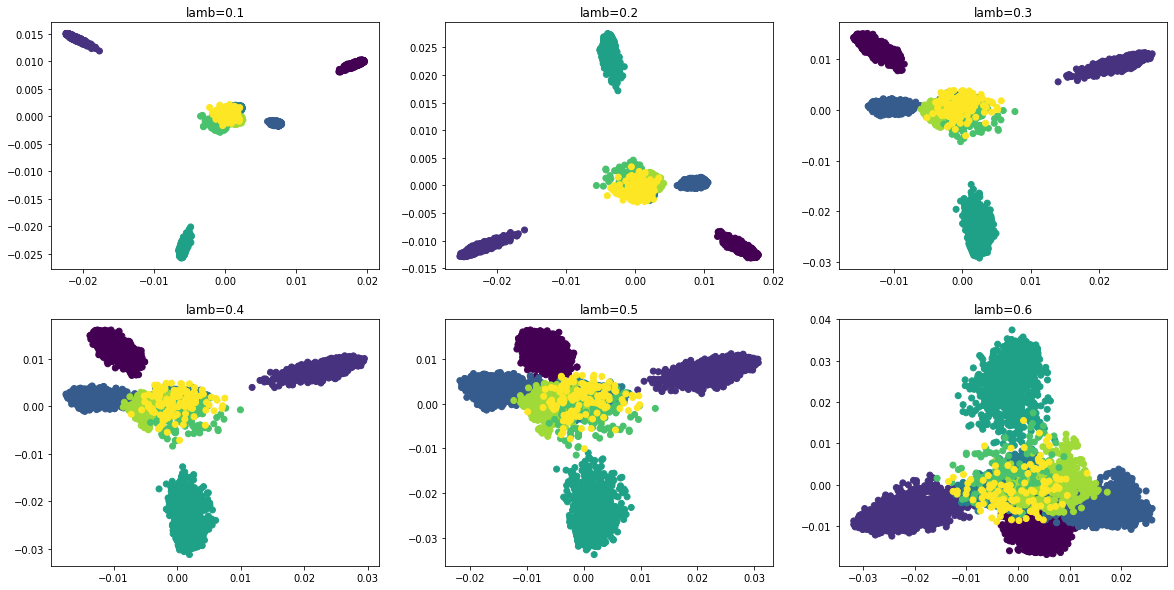

In [ ]:
#@title
if False:
  lamb = 0.1
  w_mat = lamb*wf_mat + (1-lamb)*wl_mat
  D_mat = np.diag([ np.sum(w_mat[ii]) for ii in range(ndt) ])
  L_mat = D_mat - w_mat
  eigenvalues_01, eigenvectors_01 = eigh(L_mat, b=D_mat)


  lamb = 0.2
  w_mat = lamb*wf_mat + (1-lamb)*wl_mat
  D_mat = np.diag([ np.sum(w_mat[ii]) for ii in range(ndt) ])
  L_mat = D_mat - w_mat
  eigenvalues_02, eigenvectors_02 = eigh(L_mat, b=D_mat)


  lamb = 0.4
  w_mat = lamb*wf_mat + (1-lamb)*wl_mat
  D_mat = np.diag([ np.sum(w_mat[ii]) for ii in range(ndt) ])
  L_mat = D_mat - w_mat
  eigenvalues_04, eigenvectors_04 = eigh(L_mat, b=D_mat)


  lamb = 0.5
  w_mat = lamb*wf_mat + (1-lamb)*wl_mat
  D_mat = np.diag([ np.sum(w_mat[ii]) for ii in range(ndt) ])
  L_mat = D_mat - w_mat
  eigenvalues_05, eigenvectors_05 = eigh(L_mat, b=D_mat)


  lamb = 0.6
  w_mat = lamb*wf_mat + (1-lamb)*wl_mat
  D_mat = np.diag([ np.sum(w_mat[ii]) for ii in range(ndt) ])
  L_mat = D_mat - w_mat
  eigenvalues_06, eigenvectors_06 = eigh(L_mat, b=D_mat)


  lamb = 0.3
  w_mat = lamb*wf_mat + (1-lamb)*wl_mat
  D_mat = np.diag([ np.sum(w_mat[ii]) for ii in range(ndt) ])
  L_mat = D_mat - w_mat
  eigenvalues_03, eigenvectors_03 = eigh(L_mat, b=D_mat)


  fig, ax = plt.subplots( 2, 3, figsize=(20,10) )
  ax[0][0].scatter(eigenvectors_01[:,1]/np.linalg.norm(eigenvectors_01[:,1]),
           eigenvectors_01[:,2]/np.linalg.norm(eigenvectors_01[:,2]),
           c=colors)
  ax[0][0].set_title('lamb=0.1')

  ax[0][1].scatter(eigenvectors_02[:,1]/np.linalg.norm(eigenvectors_02[:,1]),
           eigenvectors_02[:,2]/np.linalg.norm(eigenvectors_02[:,2]),
           c=colors)
  ax[0][1].set_title('lamb=0.2')

  ax[0][2].scatter(eigenvectors_03[:,1]/np.linalg.norm(eigenvectors_03[:,1]),
           eigenvectors_03[:,2]/np.linalg.norm(eigenvectors_03[:,2]),
           c=colors)
  ax[0][2].set_title('lamb=0.3')

  ax[1][0].scatter(eigenvectors_04[:,1]/np.linalg.norm(eigenvectors_04[:,1]),
           eigenvectors_04[:,2]/np.linalg.norm(eigenvectors_04[:,2]),
           c=colors)
  ax[1][0].set_title('lamb=0.4')

  ax[1][1].scatter(eigenvectors_05[:,1]/np.linalg.norm(eigenvectors_05[:,1]),
           eigenvectors_05[:,2]/np.linalg.norm(eigenvectors_05[:,2]),
           c=colors)
  ax[1][1].set_title('lamb=0.5')

  ax[1][2].scatter(eigenvectors_06[:,1]/np.linalg.norm(eigenvectors_06[:,1]),
           eigenvectors_06[:,2]/np.linalg.norm(eigenvectors_06[:,2]),
           c=colors)
  ax[1][2].set_title('lamb=0.6')

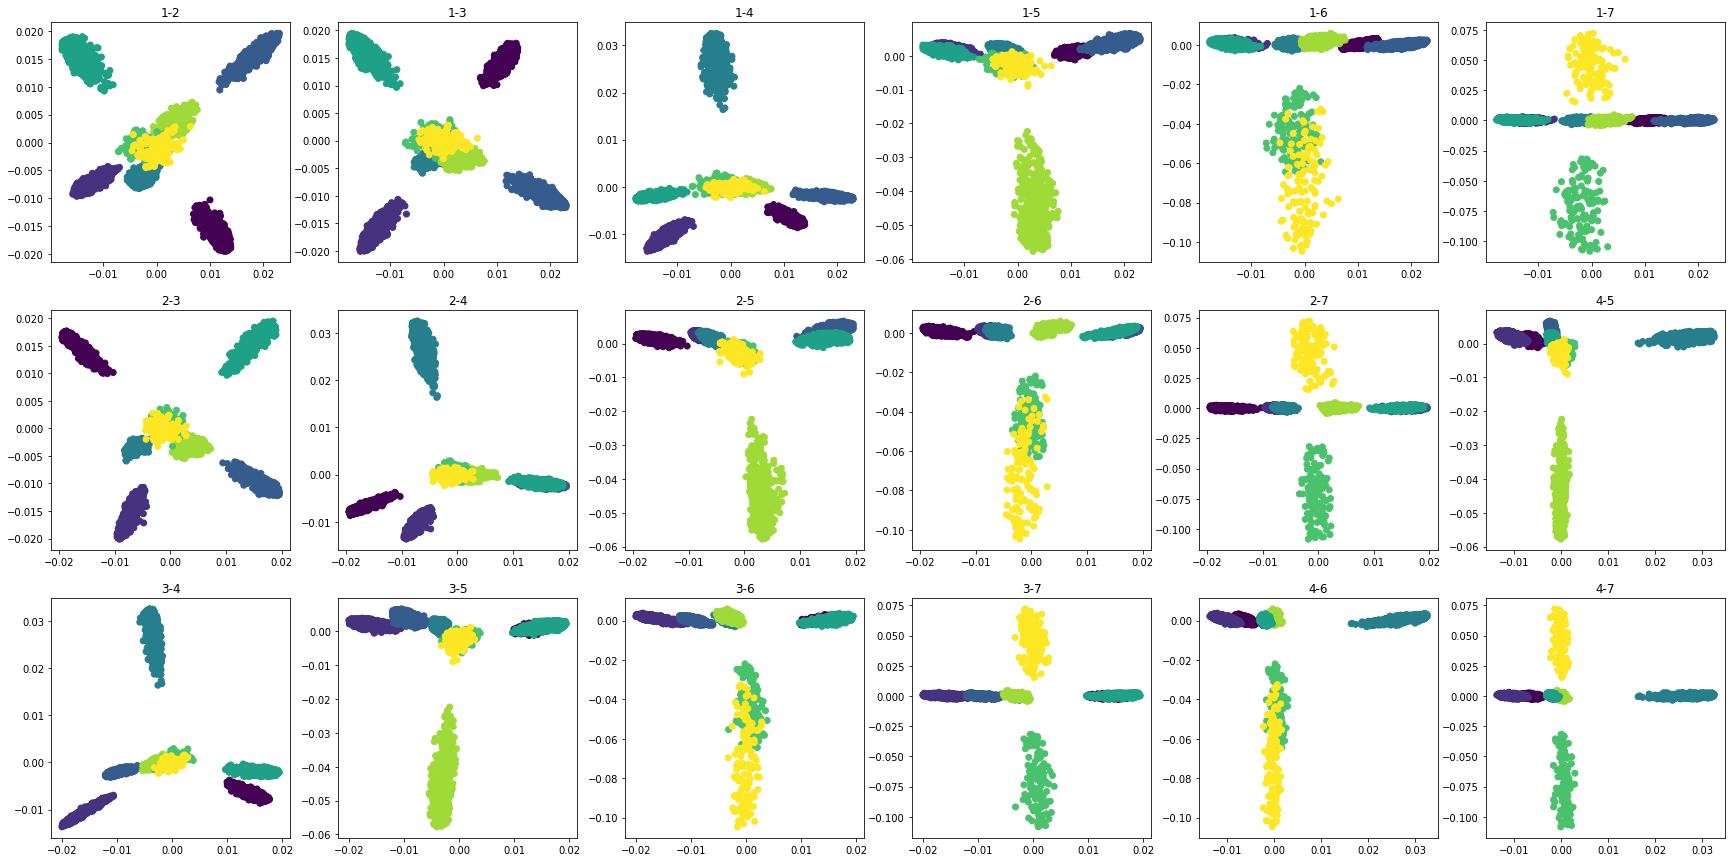

In [ ]:
#@title
def plot_variusplanes( eigenvectors_03, colors, stri='' ): 
  fig, ax = plt.subplots( 3, 6, figsize=(30,15) )


  ax[0][0].scatter(eigenvectors_03[:,1]/np.linalg.norm(eigenvectors_03[:,1]),
           eigenvectors_03[:,2]/np.linalg.norm(eigenvectors_03[:,2]),
           c=colors)
  ax[0][0].set_title(stri+'1-2')

  ax[0][1].scatter(eigenvectors_03[:,1]/np.linalg.norm(eigenvectors_03[:,1]),
           eigenvectors_03[:,3]/np.linalg.norm(eigenvectors_03[:,3]),
           c=colors)
  ax[0][1].set_title(stri+'1-3')

  ax[0][2].scatter(eigenvectors_03[:,1]/np.linalg.norm(eigenvectors_03[:,1]),
           eigenvectors_03[:,4]/np.linalg.norm(eigenvectors_03[:,4]),
           c=colors)
  ax[0][2].set_title(stri+'1-4')

  ax[0][3].scatter(eigenvectors_03[:,1]/np.linalg.norm(eigenvectors_03[:,1]),
           eigenvectors_03[:,5]/np.linalg.norm(eigenvectors_03[:,5]),
           c=colors)
  ax[0][3].set_title(stri+'1-5')

  ax[0][4].scatter(eigenvectors_03[:,1]/np.linalg.norm(eigenvectors_03[:,1]),
           eigenvectors_03[:,6]/np.linalg.norm(eigenvectors_03[:,6]),
           c=colors)
  ax[0][4].set_title(stri+'1-6')

  ax[0][5].scatter(eigenvectors_03[:,1]/np.linalg.norm(eigenvectors_03[:,1]),
           eigenvectors_03[:,7]/np.linalg.norm(eigenvectors_03[:,7]),
           c=colors)
  ax[0][5].set_title(stri+'1-7')


  ax[1][0].scatter(eigenvectors_03[:,2]/np.linalg.norm(eigenvectors_03[:,2]),
           eigenvectors_03[:,3]/np.linalg.norm(eigenvectors_03[:,3]),
           c=colors)
  ax[1][0].set_title(stri+'2-3')

  ax[1][1].scatter(eigenvectors_03[:,2]/np.linalg.norm(eigenvectors_03[:,2]),
           eigenvectors_03[:,4]/np.linalg.norm(eigenvectors_03[:,4]),
           c=colors)
  ax[1][1].set_title(stri+'2-4')

  ax[1][2].scatter(eigenvectors_03[:,2]/np.linalg.norm(eigenvectors_03[:,2]),
           eigenvectors_03[:,5]/np.linalg.norm(eigenvectors_03[:,5]),
           c=colors)
  ax[1][2].set_title(stri+'2-5')

  ax[1][3].scatter(eigenvectors_03[:,2]/np.linalg.norm(eigenvectors_03[:,2]),
           eigenvectors_03[:,6]/np.linalg.norm(eigenvectors_03[:,6]),
           c=colors)
  ax[1][3].set_title(stri+'2-6')

  ax[1][4].scatter(eigenvectors_03[:,2]/np.linalg.norm(eigenvectors_03[:,2]),
           eigenvectors_03[:,7]/np.linalg.norm(eigenvectors_03[:,7]),
           c=colors)
  ax[1][4].set_title(stri+'2-7')

  ax[1][5].scatter(eigenvectors_03[:,4]/np.linalg.norm(eigenvectors_03[:,4]),
           eigenvectors_03[:,5]/np.linalg.norm(eigenvectors_03[:,5]),
           c=colors)
  ax[1][5].set_title(stri+'4-5')



  ax[2][0].scatter(eigenvectors_03[:,3]/np.linalg.norm(eigenvectors_03[:,3]),
           eigenvectors_03[:,4]/np.linalg.norm(eigenvectors_03[:,4]),
           c=colors)
  ax[2][0].set_title(stri+'3-4')

  ax[2][1].scatter(eigenvectors_03[:,3]/np.linalg.norm(eigenvectors_03[:,3]),
           eigenvectors_03[:,5]/np.linalg.norm(eigenvectors_03[:,5]),
           c=colors)
  ax[2][1].set_title(stri+'3-5')

  ax[2][2].scatter(eigenvectors_03[:,3]/np.linalg.norm(eigenvectors_03[:,3]),
           eigenvectors_03[:,6]/np.linalg.norm(eigenvectors_03[:,6]),
           c=colors)
  ax[2][2].set_title(stri+'3-6')

  ax[2][3].scatter(eigenvectors_03[:,3]/np.linalg.norm(eigenvectors_03[:,3]),
           eigenvectors_03[:,7]/np.linalg.norm(eigenvectors_03[:,7]),
           c=colors)
  ax[2][3].set_title(stri+'3-7')

  ax[2][4].scatter(eigenvectors_03[:,4]/np.linalg.norm(eigenvectors_03[:,4]),
           eigenvectors_03[:,6]/np.linalg.norm(eigenvectors_03[:,6]),
           c=colors)
  ax[2][4].set_title(stri+'4-6')

  ax[2][5].scatter(eigenvectors_03[:,4]/np.linalg.norm(eigenvectors_03[:,4]),
           eigenvectors_03[:,7]/np.linalg.norm(eigenvectors_03[:,7]),
           c=colors)
  ax[2][5].set_title(stri+'4-7')

  return

plot_variusplanes( eigenvectors_03, colors )  

In [ ]:
summ = np.zeros(ndt)
for ii in range(ndt):
  for jj in gt_D[ii]:
    summ[ii] += jj 
sig2 = np.sum(summ)/(nnn*ndt)

xb_xb = np.matmul(xb,xb.T)

print(sig2)

425.6195230063435


In [ ]:
K_mat = np.zeros((ndt,ndt))
K_mat_100 = np.zeros((ndt,ndt))
K_mat100 = np.zeros((ndt,ndt))
K_mat_10000 = np.zeros((ndt,ndt))
K_mat10000 = np.zeros((ndt,ndt))

dubls = []
for ii in tqdm(range(ndt)):
  for jj in range(ii,ndt):
    dd = (xb_xb[ii,ii]+xb_xb[jj,jj]-2*xb_xb[ii,jj])
    pp = np.exp( -dd/sig2 )
    pp_100 = np.exp( -dd/(100*sig2) )
    pp100 = np.exp( -dd*100/sig2 )
    pp_10000 = np.exp( -dd/(10000*sig2) )
    pp10000 = np.exp( -dd*10000/sig2 )
    K_mat[ii,jj] = pp
    K_mat[jj,ii] = pp
    K_mat100[ii,jj] = pp100
    K_mat100[jj,ii] = pp100    
    K_mat_100[ii,jj] = pp_100
    K_mat_100[jj,ii] = pp_100
    K_mat10000[ii,jj] = pp10000
    K_mat10000[jj,ii] = pp10000    
    K_mat_10000[ii,jj] = pp_10000
    K_mat_10000[jj,ii] = pp_10000
    if jj !=ii and np.abs(dd)<1e-6:
      print(jj,' is very close to ', ii,'  distance  ',dd)
      dubls.append([jj,ii])

from scipy.linalg import pinvh
K_inv, rank_K = pinvh(K_mat, return_rank=True)    
print('rank of K_mat',rank_K)
K_inv100, rank_K100 = pinvh(K_mat100, return_rank=True)    
print('rank of K_mat100',rank_K100) 
K_inv_100, rank_K_100 = pinvh(K_mat_100, return_rank=True)    
print('rank of K_mat_100',rank_K_100)  
K_inv10000, rank_K10000 = pinvh(K_mat10000, return_rank=True)    
print('rank of K_mat10000',rank_K10000) 
K_inv_10000, rank_K_10000 = pinvh(K_mat_10000, return_rank=True)    
print('rank of K_mat_10000',rank_K_10000)    

  0%|          | 0/5958 [00:00<?, ?it/s]

5701  is very close to  261   distance   0.0
2466  is very close to  363   distance   0.0
5337  is very close to  379   distance   0.0
3315  is very close to  829   distance   0.0
2453  is very close to  938   distance   0.0
2911  is very close to  954   distance   0.0
5489  is very close to  1272   distance   0.0
5499  is very close to  2803   distance   0.0
5719  is very close to  2985   distance   0.0
4385  is very close to  3244   distance   0.0
4705  is very close to  3293   distance   0.0
4323  is very close to  3419   distance   0.0
4567  is very close to  3458   distance   0.0
5578  is very close to  3459   distance   0.0
5775  is very close to  3459   distance   0.0
5816  is very close to  3477   distance   0.0
4287  is very close to  3645   distance   0.0
4347  is very close to  3783   distance   0.0
4538  is very close to  3811   distance   0.0
4491  is very close to  3918   distance   0.0
4504  is very close to  4030   distance   0.0
5043  is very close to  4061   distance 

In [ ]:
print(y[5652])
print(y[5826])

['fer0016009.png' '4']
['fer0027855.png' '5']


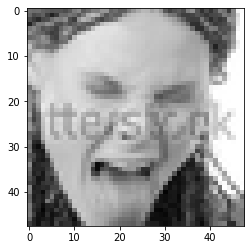

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/Images/FER2013Train/fer0016009.png')
img2 = cv2.imread('/content/drive/MyDrive/Images/FER2013Train/fer0027855.png')
show(img1)

True

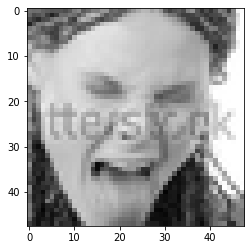

In [ ]:
show(img2)
np.all(img1 == img2)

we see the same image with different name and label. This makes our K_mat Singular 

In [ ]:
#Drop duplicates
lamb = 0.3
w_mat = lamb*wf_mat + (1-lamb)*wl_mat
sz0 = w_mat.shape[0]
szn = sz0 - np.unique([ ii[0] for ii in dubls ]).shape[0]
mask = np.ones((sz0,sz0),dtype=bool)
for ii in dubls:
  mask[:,ii[0]] = False
  mask[ii[0],:] = False

w_mat_cl = (w_mat[ mask,... ]).reshape(szn,szn)  

D_mat_cl = np.diag([ np.sum(w_mat_cl[ii]) for ii in range(szn) ])
L_mat_cl = D_mat_cl - w_mat_cl

eigenvalues_03, eigenvectors_03 = eigh(L_mat_cl, b=D_mat_cl)

K_mat_cl = (K_mat[ mask,... ]).reshape(szn,szn)
K_mat100_cl = (K_mat100[ mask,... ]).reshape(szn,szn)
K_mat_100_cl = (K_mat_100[ mask,... ]).reshape(szn,szn)
K_mat10000_cl = (K_mat10000[ mask,... ]).reshape(szn,szn)
K_mat_10000_cl = (K_mat_10000[ mask,... ]).reshape(szn,szn)

K_inv, rank_K = pinvh(K_mat_cl, return_rank=True)    
print('rank of K_mat',rank_K)
K_inv100, rank_K100 = pinvh(K_mat100_cl, return_rank=True)    
print('rank of K_mat100',rank_K100) 
K_inv_100, rank_K_100 = pinvh(K_mat_100_cl, return_rank=True)    
print('rank of K_mat_100',rank_K_100)  
K_inv10000, rank_K10000 = pinvh(K_mat10000_cl, return_rank=True)    
print('rank of K_mat10000',rank_K10000) 
K_inv_10000, rank_K_10000 = pinvh(K_mat_10000_cl, return_rank=True)    
print('rank of K_mat_10000',rank_K_10000)

colors_cl = []
for ii,c in enumerate(colors):
  if ii not in np.array(dubls)[:,0]:
    colors_cl.append(c)

rank of K_mat 5932
rank of K_mat100 5932
rank of K_mat_100 5932
rank of K_mat10000 5932
rank of K_mat_10000 5931


In [ ]:
for ii in range(eigenvectors_03.shape[0]):
  eigenvectors_03[:,ii] = eigenvectors_03[:,ii]/np.linalg.norm(eigenvectors_03[:,ii])

ci_s = K_inv @ eigenvectors_03
print(np.allclose(eigenvectors_03, K_mat_cl @ ci_s))

ci_s100 = K_inv100 @ eigenvectors_03
print('100 ',np.allclose(eigenvectors_03, K_mat100_cl @ ci_s100))

ci_s_100 = K_inv_100 @ eigenvectors_03
print('_100 ',np.allclose(eigenvectors_03, K_mat_100_cl @ ci_s_100))

ci_s10000 = K_inv10000 @ eigenvectors_03
print('10000 ',np.allclose(eigenvectors_03, K_mat10000_cl @ ci_s10000))

ci_s_10000 = K_inv_10000 @ eigenvectors_03
print('_10000 ',np.allclose(eigenvectors_03, K_mat_10000_cl @ ci_s_10000))


True
100  True
_100  False
10000  True
_10000  False


## Testing the Method
In this section we test the Laplacian Map Clustering Method

In [ ]:
stringi = 'Test'
dbname = f'memap_AllFeatures_{stringi}_X'
dim = 52234
xt = np.memmap(os.path.join(main_path,dbname),dtype='float32',mode='r')
xt = xt.reshape((-1,dim))
ndt = xt.shape[0]
yt = np.memmap(os.path.join(main_path,f'memap_AllFeatures_{stringi}_y'),dtype='<U14',shape=(ndt,2))

In [ ]:
xt_xb = np.matmul(xt,xb.T)
xt_xt = np.matmul(xt,xt.T)

sze_trans = xt_xb.shape

K_trans = np.zeros(sze_trans)
K_trans100 = np.zeros(sze_trans)
K_trans_100 = np.zeros(sze_trans) #do not use because test "_10000 False" 
K_trans10000 = np.zeros(sze_trans)
K_trans_10000 = np.zeros(sze_trans) #do not use because test "_10000 False" 

for ii in tqdm(range(sze_trans[0])):
  for jj in range(sze_trans[1]):
    dd = (xt_xt[ii,ii]+xb_xb[jj,jj]-2*xt_xb[ii,jj])
    pp = np.exp( -dd/sig2 )
    pp_100 = np.exp( -dd/(100*sig2) )
    pp100 = np.exp( -dd*100/sig2 )
    pp_10000 = np.exp( -dd/(10000*sig2) )
    pp10000 = np.exp( -dd*10000/sig2 )     
    K_trans[ii,jj] = pp
    K_trans100[ii,jj] = pp100
    K_trans10000[ii,jj] = pp10000
    K_trans_100[ii,jj] = pp_100
    K_trans_10000[ii,jj] = pp_10000



  0%|          | 0/3044 [00:00<?, ?it/s]

In [ ]:
sz00 = K_trans.shape[0]
sz01 = K_trans.shape[1]
szn = sz01 - np.unique([ ii[0] for ii in dubls ]).shape[0]
mask = np.ones((sz00,sz01),dtype=bool)
for ii in dubls:
  mask[:,ii[0]] = False

K_trans_cl = (K_trans[ mask,... ]).reshape(sz00,szn)
K_trans_cl100 = (K_trans100[ mask,... ]).reshape(sz00,szn)
K_trans_cl10000 = (K_trans10000[ mask,... ]).reshape(sz00,szn)
K_trans_cl_100 = (K_trans_100[ mask,... ]).reshape(sz00,szn)
K_trans_cl_10000 = (K_trans_10000[ mask,... ]).reshape(sz00,szn)


In [ ]:
proj = K_trans_cl @ ci_s
proj100 = K_trans_cl100 @ ci_s100
proj10000 = K_trans_cl10000 @ ci_s10000
proj_100 = K_trans_cl_100 @ ci_s_100 
proj_10000 = K_trans_cl_10000 @ ci_s_10000

df_train = pd.DataFrame({'dim 1': eigenvectors_03[:,1], 'dim 2': eigenvectors_03[:,2], 'dim 3': eigenvectors_03[:,3],
                         'dim 4': eigenvectors_03[:,4], 'dim 5': eigenvectors_03[:,5], 'dim 6': eigenvectors_03[:,6],
                         'dim 7': eigenvectors_03[:,7]})#, 'dim 8': eigenvectors_03[:,8], 'dim 9': eigenvectors_03[:,9]})   #since there are 8 labels use 7 dimentions

df_train['label'] = colors_cl
df_train.sample(frac=1)

df_train_l = df_train['label']
df_train = df_train.drop(['label'], axis=1)

df_test_l = pd.DataFrame({'label': yt[:,1].astype('int')})

def classifiy_label( proj, classifier_name ):
  if classifier_name == 'DecisionTree':
        classif = DecisionTreeClassifier(max_depth=4)
        def ClassifierFunction( ):
            return classif.fit( df_train, df_train_l )
        
  elif classifier_name == 'LogisticRegression':
        classif = LogisticRegression(solver='lbfgs', max_iter=1000)
        def ClassifierFunction( ):
            return classif.fit( df_train, df_train_l )
    
  elif classifier_name == 'RandomForest':
        classif = RandomForestClassifier(max_depth=100)
        def ClassifierFunction( ):
            return classif.fit( df_train, df_train_l )

  elif classifier_name == 'KNN':
        classif = KNeighborsClassifier(n_neighbors=8*10+1)
        def ClassifierFunction( ):
            return classif.fit( df_train, df_train_l )

  df_test = pd.DataFrame({'dim 1': proj[:,1], 'dim 2': proj[:,2], 'dim 3': proj[:,3],
                          'dim 4': proj[:,4], 'dim 5': proj[:,5], 'dim 6': proj[:,6],
                          'dim 7': proj[:,7]})#, 'dim 8': proj[:,8], 'dim 9': proj[:,9]})   #since there are 8 labels use 7 dimentions 
  
  print( '######################' )
  print( 'Training' )
  classificated = ClassifierFunction( )
  print( '...' )                           
  print( 'Testing' )
  accuracy_test = sklearn.metrics.accuracy_score(df_test_l,classificated.predict(df_test))
  print( 'Accuracy:', accuracy_test)
  print( 'confusion matrix' )
  print( sklearn.metrics.confusion_matrix( df_test_l, classificated.predict(df_test)  ) )




In [ ]:
for classif in ['DecisionTree', 'LogisticRegression', 'RandomForest', 'KNN'] :
  print(f'\n\nAccuracy  for sig2 {sig2} and lamb {lamb} and classifier {classif}')
  classifiy_label( proj, classif )



Accuracy  for sig2 425.6195230063435 and lamb 0.3 and classifier DecisionTree
######################
Training
...
Testing
Accuracy: 0.4467805519053876
confusion matrix
[[370 121  79 510  32   0   0   0]
 [101 405   5 142 141   0   0   0]
 [  4  48 243  83   5   0   0   0]
 [ 66   3  15 219  45   0   0   0]
 [  5  36   3 105 123   0   0   0]
 [  0   1   1  11   5   0   0   0]
 [  0   4  20  61   5   0   0   0]
 [  4   0   0  20   3   0   0   0]]


Accuracy  for sig2 425.6195230063435 and lamb 0.3 and classifier LogisticRegression
######################
Training
...
Testing
Accuracy: 0.7217477003942181
confusion matrix
[[831 102  48  66  65   0   0   0]
 [ 32 709  16  11  26   0   0   0]
 [ 45  18 296   3  19   0   2   0]
 [114  50   7 145  32   0   0   0]
 [ 27  13  12  12 208   0   0   0]
 [  2   6   1   1   8   0   0   0]
 [ 11  16  32  12  11   0   8   0]
 [  8   9   2   4   4   0   0   0]]


Accuracy  for sig2 425.6195230063435 and lamb 0.3 and classifier RandomForest
############

In [ ]:
classif = 'KNN'
print(f'\n\nAccuracy  for sig2 {sig2/100} and lamb {lamb} and classifier {classif}')
classifiy_label( proj100, classif )
print(f'\n\nAccuracy  for sig2 {sig2*100} and lamb {lamb} and classifier {classif}')
classifiy_label( proj_100, classif )
print(f'\n\nAccuracy  for sig2 {sig2/10000} and lamb {lamb} and classifier {classif}')
classifiy_label( proj10000, classif )
print(f'\n\nAccuracy  for sig2 {sig2*10000} and lamb {lamb} and classifier {classif}')
classifiy_label( proj_10000, classif )



Accuracy  for sig2 4.256195230063435 and lamb 0.3 and classifier KNN
######################
Training
...
Testing


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.2871222076215506
confusion matrix
[[   1 1107    2    2    0    0    0    0]
 [   0  794    0    0    0    0    0    0]
 [   1  336   42    0    0    0    4    0]
 [   2  336    0    9    0    1    0    0]
 [   0  254    1    0   16    0    0    1]
 [   0   15    0    0    0    3    0    0]
 [   0   77    2    1    3    0    7    0]
 [   0   25    0    0    0    0    0    2]]


Accuracy  for sig2 42561.95230063435 and lamb 0.3 and classifier KNN
######################
Training
...
Testing


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.6064388961892248
confusion matrix
[[573  86 130 177  78   0  65   3]
 [ 34 602  62  34  35   0  27   0]
 [ 33  10 276  11  17   0  36   0]
 [ 76  23  36 159  25   1  25   3]
 [ 19   6  31  22 179   0  14   1]
 [  1   1   2   0   7   7   0   0]
 [  4   5  26   9   7   0  39   0]
 [  3   3   2   5   1   0   2  11]]


Accuracy  for sig2 0.04256195230063435 and lamb 0.3 and classifier KNN
######################
Training
...
Testing


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.2871222076215506
confusion matrix
[[   1 1108    1    2    0    0    0    0]
 [   0  794    0    0    0    0    0    0]
 [   1  337   42    0    0    0    3    0]
 [   2  336    0    9    0    1    0    0]
 [   0  254    1    0   16    0    0    1]
 [   0   15    0    0    0    3    0    0]
 [   0   78    2    1    2    0    7    0]
 [   0   25    0    0    0    0    0    2]]


Accuracy  for sig2 4256195.230063435 and lamb 0.3 and classifier KNN
######################
Training
...
Testing


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.6383048620236531
confusion matrix
[[623  88  79 195  90   0  34   3]
 [ 40 625  33  41  38   0  17   0]
 [ 41  11 275  12  14   0  30   0]
 [ 85  25   9 174  36   1  15   3]
 [ 23   9  15  25 191   0   8   1]
 [  1   1   2   1   7   6   0   0]
 [  2   5  23  14   8   0  38   0]
 [  5   4   0   5   2   0   0  11]]


In [ ]:
def LambSig( sig2, lamb=0.3, classif='KNN' ):
  #gives the accuracy and confussion matrix for the given parameters
  #note tha uses the following variables:
  #      wf_mat
  #      wl_mat 
  #      dubls
  #      xt_xt
  #      xt_xb
  #      xb_xb
  #      df_test
  #      df_test_l
  #      df_train
  #      df_train_l

  #Eigen vectors wanted:
  w_mat = lamb*wf_mat + (1-lamb)*wl_mat
  sz0 = w_mat.shape[0]
  szn = sz0 - np.unique([ ii[0] for ii in dubls ]).shape[0]
  mask = np.ones((sz0,sz0),dtype=bool)
  for ii in dubls:
    mask[:,ii[0]] = False
    mask[ii[0],:] = False

  w_mat_cl = (w_mat[ mask,... ]).reshape(szn,szn)  

  D_mat_cl = np.diag([ np.sum(w_mat_cl[ii]) for ii in range(szn) ])
  L_mat_cl = D_mat_cl - w_mat_cl

  eigenvalues_03, eigenvectors_03 = eigh(L_mat_cl, b=D_mat_cl)

  for ii in range(eigenvectors_03.shape[0]):
    eigenvectors_03[:,ii] = eigenvectors_03[:,ii]/np.linalg.norm(eigenvectors_03[:,ii])


  #K matrix

  K_mat = np.zeros(xb_xb.shape)

  sze_trans = xt_xb.shape
  K_trans = np.zeros(sze_trans)

  for ii in tqdm(range(sze_trans[1])):
    for jj in range(sze_trans[0]):
      dd = (xt_xt[jj,jj]+xb_xb[ii,ii]-2*xt_xb[jj,ii])
      pp = np.exp( -dd/sig2 ) 
      K_trans[jj,ii] = pp
    for jj in range(ii,sze_trans[1]):
      dd = (xb_xb[jj,jj]+xb_xb[ii,ii]-2*xb_xb[jj,ii])
      pp = np.exp( -dd/sig2 ) 
      K_mat[jj,ii] = pp
      K_mat[ii,jj] = pp

  K_mat_cl = (K_mat[ mask,... ]).reshape(szn,szn) 
  
  K_inv, rank_K = pinvh(K_mat_cl, return_rank=True)    
  print('rank of K_mat_cl - shape  ',rank_K - K_mat_cl.shape[0])

  ci_s = K_inv @ eigenvectors_03
  print('M-P inverse is good?  ',np.allclose(eigenvectors_03, K_mat_cl @ ci_s))

  sz00 = K_trans.shape[0]
  sz01 = K_trans.shape[1]
  szn = sz01 - np.unique([ ii[0] for ii in dubls ]).shape[0]
  mask_trans = np.ones((sz00,sz01),dtype=bool)
  for ii in dubls:
    mask_trans[:,ii[0]] = False

  K_trans_cl = (K_trans[ mask_trans,... ]).reshape(sz00,szn)    

  proj = K_trans_cl @ ci_s

  print(f'\n\nAccuracy  for sig2 {sig2} and lamb {lamb} and classifier {classif}')
  classifiy_label(proj,classif)


In [ ]:
LambSig(sig2,lamb=0.4)

  0%|          | 0/5958 [00:00<?, ?it/s]

rank of K_mat_cl - shape   0
M-P inverse is good?   True


Accuracy  for sig2 425.6195230063435 and lamb 0.4 and classifier KNN
######################
Training
...
Testing


/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


Accuracy: 0.7105781865965834
confusion matrix
[[750  93  41 145  78   1   3   1]
 [ 20 686  28  29  29   0   2   0]
 [ 41  11 299   8  13   0  11   0]
 [ 83  26   8 180  40   4   7   0]
 [ 26   9  18  15 199   1   4   0]
 [  0   2   1   1   8   6   0   0]
 [  8   4  28   9   5   0  36   0]
 [  4   2   1   6   3   4   0   7]]


In [ ]:
print(df_test_l.value_counts())
print(df_train_l.value_counts())

label
0        1112
1         794
2         383
3         348
4         272
6          90
7          27
5          18
dtype: int64
label
1        1110
0        1095
4        1051
2        1020
3         958
6         446
7         128
5         124
dtype: int64


We see that the classification has problems with labels [5, 6, 7], which are the ones with less frequency in our train data. The label which we classificate the best is [1], which incidentally is the one who chosen by 'KNN' for almost all the images when **sig2** is low.
Although this Feature reduction by means of "Kernelized Supervised Laplacian Eigenmap" is interesting. It might be necessary to mix it with CNN to achieve better results in our problem.
Further parameter tuning can be done to improve our results in the test set. When the "right parameters" are found, we can use the validation set to see if indeed  we choose good parameters.